<a href="https://colab.research.google.com/github/jnofech/phangs_repo/blob/master/galaxies/diskfit_mom1_7m/diskfit_input_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Important paths!
import sys
sys.path.insert(0, '/media/jnofech/BigData/galaxies/')
sys.path.insert(0, '/media/jnofech/BigData/galaxies/VLA_Lband/')
sys.path.insert(0, '/media/jnofech/BigData/jnofech_codes/')
sys.path.insert(0, '/media/jnofech/BigData/')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import corner
import math

import astropy.io.fits as fits
import astropy.units as u
import astropy.wcs as wcs
from astropy.wcs import WCS
from astropy.table import Table
from astropy.convolution import convolve_fft, Gaussian2DKernel
from spectral_cube import SpectralCube, Projection
from radio_beam import Beam
from galaxies.galaxies import Galaxy
from astropy.coordinates import SkyCoord, Angle, FK5

from scipy import ndimage, misc, interpolate, signal, optimize
from scipy.interpolate import BSpline, make_lsq_spline
from pandas import DataFrame, read_csv
import pandas as pd
import statsmodels.formula.api as smf

from itertools import count, cycle

import copy
import os.path
import subprocess
from importlib import reload

# Import Eric's plotting defaults
import sys
sys.path.insert(0, 'VLA_Lband/')
import plotting_styles as ps

# Import my own code
import rotcurve_tools as rc
import galaxytools as tools
import diskfit_input_generator as dig


# Plotting Settings
ps.default_figure()
#ps.onecolumn_figure()
#ps.onecolumn_twopanel_figure
#ps.twocolumn_figure()
#ps.twocolumn_twopanel_figure()

sns.set_context('poster')


# Import silencer
import os, sys
class silence:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
with silence():
    print("This will not be printed")


ignorewarnings = True

if ignorewarnings==True:
    import warnings
    warnings.filterwarnings("ignore")
else:
    import warnings
    warnings.resetwarnings()

/home/jnofech/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:201: UserWarning: In /home/jnofech/.config/matplotlib/stylelib/paper_detailed.mplstyle: Duplicate key in file "/home/jnofech/.config/matplotlib/stylelib/paper_detailed.mplstyle", line #44
  warnings.warn(message)
/home/jnofech/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:201: UserWarning: In /home/jnofech/.config/matplotlib/stylelib/paper_detailed.mplstyle: Duplicate key in file "/home/jnofech/.config/matplotlib/stylelib/paper_detailed.mplstyle", line #45
  warnings.warn(message)
/home/jnofech/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:201: UserWarning: In /home/jnofech/.config/matplotlib/stylelib/paper_detailed.mplstyle: Duplicate key in file "/home/jnofech/.config/matplotlib/stylelib/paper_detailed.mplstyle", line #46
  warnings.warn(message)
/home/jnofech/anaconda3/lib/python3.6/site-packages/matplotlib/style/core.py:201: UserWarning: In /home/jnofech/.config/matplotlib

In [0]:
def p_vrot(Rd,vrotd,vrot_ed,vmin=-10,vmax=450,\
           PA_orig=np.nan,PA_fit=np.nan,incl_orig=np.nan,incl_fit=np.nan,vsys_orig=np.nan,vsys_fit=np.nan,\
           bar_PA_orig=np.nan,bar_PA_fit=np.nan,\
           vobs=None,rad=None,index=None):
    if vobs is not None and rad is not None and index is not None:
        plt.plot(rad[index_narrow], vobs[index_narrow],'k.',alpha=0.1*(data_mode=='7m') \
                 + np.max([2000./index.size,0.002])*(data_mode in ['12m','12m+7m','hybrid']))
        plt.plot(rad[index_wide&~index_narrow], vobs[index_wide&~index_narrow],'k+',mew=0.7,alpha=0.08*(data_mode=='7m') \
                 + np.max([2000./index.size,0.002])*(data_mode in ['12m','12m+7m','hybrid']))
    else:
        print('LALALALAL')
        
    (_,cap1,_) = plt.errorbar(Rd,vrotd,yerr=vrot_ed, fmt='',\
                 label='DiskFit (auto)',c='red',alpha=0.6,capsize=5)
    plt.legend(loc='upper left')
    plt.xlabel('Radius~(pixels)',size=25)
    plt.ylabel('$v_{rot}~(km/s)$',size=25)
    if showtitle==True:
        plt.title('Rotation Curve - '+name.upper()+' ('+data_mode+")",size=25)
#     plt.gcf().set_size_inches(9,7)
    plt.gcf().set_size_inches(base_width,0.85*base_width)
#     plt.tight_layout()
    plt.ylim([vmin,vmax])
    for cap in cap1:
        #cap.set_color('k')
        cap.set_markeredgewidth(1)
    
    
    # Add table of parameters (initial LEDA values, initial values, and values after fit).
    if ~np.isnan(PA_orig*PA_fit*incl_orig*incl_fit*vsys_orig*vsys_fit):
        col_labels=['Leda','Original','Fitted']
        row_labels=['PA ($^{\circ}$)','incl ($^{\circ}$)','vsys ($km/s$)']
        table_vals=[["{0:4.1f}".format(PA_leda.value),"{0:4.1f}".format(PA_orig.value),"{0:4.1f}".format(PA_fit.value)],\
                    ["{0:4.1f}".format(incl_leda.value),"{0:4.1f}".format(incl_orig.value),"{0:4.1f}".format(incl_fit.value)],\
                    ["{0:4.1f}".format(vsys_leda.value),"{0:4.1f}".format(vsys_orig.value),"{0:4.1f}".format(vsys_fit.value)]]
        if ~np.isnan(bar_PA_orig) and bar_fit_try==True:
            row_labels.append('Bar PA ($^{\circ}$)')
            if bar_PA_fit is not np.nan:
                table_vals.append(["n/a","{0:4.1f}".format(bar_PA_orig.value),"{0:4.1f}".format(bar_PA_fit.value)])
            else:
                table_vals.append(["{0:4.1f}".format(bar_PA_orig.value),"FAILED"])
        the_table = plt.table(cellText=table_vals,
                      colWidths = [0.12]*3,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='lower center')
        the_table.scale(1.3,1.8)
    # Saving:
    plt.savefig('/media/jnofech/BigData/galaxies/'+folder+'/Output/'\
                +name+'_rotcurve_'+rcmode+'.png')

## Select galaxy list!
Note:  
`galaxies_list` refers to the entire sample of primary target galaxies with available data.  
`galaxies_set` refers to the set of galaxies that we choose to use in the main loop-- it can be anything from `galaxies_list` itself to just a single galaxy.

In [0]:
# 7m Dataset!
galaxies_list  = ['IC1954','IC5273','IC5332','NGC0628','NGC0685',\
                   'NGC1087','NGC1097','NGC1300','NGC1317','NGC1365',\
                   'NGC1385','NGC1433','NGC1511','NGC1512','NGC1546',\
                   'NGC1559','NGC1566','NGC1637','NGC1672','NGC1792',\
                   'NGC1809','NGC2090','NGC2283','NGC2566','NGC2775',\
                   'NGC2835','NGC2903','NGC2997','NGC3059','NGC3137',\
                   'NGC3239','NGC3351','NGC3507','NGC3511','NGC3521',\
                   'NGC3596','NGC3621','NGC3626','NGC3627','NGC4207',\
                   'NGC4254','NGC4293','NGC4298','NGC4303','NGC4321',\
                   'NGC4424','NGC4457','NGC4496A','NGC4535','NGC4536',\
                   'NGC4540','NGC4548','NGC4569','NGC4571','NGC4579',\
                   'NGC4654','NGC4689','NGC4694','NGC4731','NGC4781',\
                   'NGC4826','NGC4941','NGC4951','NGC5042','NGC5068',\
                   'NGC5128','NGC5134','NGC5248','NGC5530','NGC5643',\
                   'NGC6300','NGC6744','NGC7456','NGC7496']
# # 12m Dataset
# galaxies_list = ['IC1954','IC5273','IC5332','NGC0628','NGC0685',\
#                     'NGC1317','NGC1365','NGC1511','NGC1672','NGC1809',\
#                     'NGC2090','NGC2283','NGC2566','NGC2775','NGC2835',\
#                     'NGC3059','NGC3137','NGC3239','NGC3351','NGC3507',\
#                     'NGC3511','NGC3596','NGC3626','NGC3627','NGC4207',\
#                     'NGC4254','NGC4293','NGC4298','NGC4303','NGC4321',\
#                     'NGC4424','NGC4457','NGC4535','NGC4540','NGC4548',\
#                     'NGC4569','NGC4571','NGC4579','NGC4654','NGC4689',\
#                     'NGC4694','NGC4826','NGC4941','NGC4951','NGC5042',\
#                     'NGC5068','NGC5134','NGC5248','NGC5530','NGC5643',\
#                     'NGC6300','NGC6744','NGC7456','NGC7496']

galaxies_bad = ['NGC3239']   # Skip over these galaxies entirely. (n3239 doesn't have a position angle.)
galaxies_crash = []

In [0]:
# Select data! 
# This should NOT change for each folder (e.g. data_mode='7m', mapmode='mom1' is only compatible with
#    a folder name of 'diskfit_auto_mom1_7m/').

data_mode = '7m'
mapmode   = 'mom1'
masking = 'broad'
err=True            # Toggles whether error maps are considered. (If err=True but an error map is missing,
                    #   dig.py will toggle error maps off for that galaxy and run DiskFit anyways.)

# --------------------------------------------------------------------------
# Generating folder name and variables; do not touch
if mapmode in ['peakvels','vpeak']:
    mapmode = 'vpeak'
if data_mode in ['12m','12m+7m']:
    data_mode = '12m+7m'
if data_mode.lower() in ['both','hybrid']:
    data_mode = 'hybrid'  
    data_mode_temp = '12m+7m'
else:
    data_mode_temp = data_mode

rcmode = mapmode+'_'+data_mode    # 'RC comes from <mapmode> data at <data_mode> resolution.' (used in filenames)
folder='diskfit_auto_'+rcmode+'/' # Current folder. (Since dig.py is a directory up from this one)
print(folder)

diskfit_auto_mom1_7m/


## Run DiskFit iterations for all galaxies!
(Be sure to empty the `Output/` folder frequently when trying out different settings! If DiskFit crashes and the folder wasn't emptied beforehand, then any successful output files from previous runs may be mistakenly treated as "successful outputs".)

(Also, `galaxies_lowincl` is a list of galaxies with the 18.19deg issue. The list gets populated as the code loops through the specified `galaxies_set`. If this information is useful, be sure to save the list somewhere after the code is done running!)

In [0]:
reload(dig)
reload(tools)

<module 'galaxytools' from '/media/jnofech/BigData/galaxies/galaxytools.py'>

In [0]:
# Settings

## Select a set of galaxies!
# galaxies_set = galaxies_crash
galaxies_set = galaxies_list
#galaxies_set = galaxies_list[0:5]
# galaxies_set = galaxies_redo
# galaxies_set = ['NGC3627','NGC4254','NGC4321','NGC5068','NGC6744']  # Galaxies with 7m+tp data but no 7m+tp emom1
# galaxies_set = ['NGC0628','NGC1317','NGC3596','NGC4303','NGC5643']  # Galaxies with very low inclinations
# galaxies_set = ['NGC7456']
# galaxies_set = ['NGC4293']
# galaxies_set = ['NGC4694']
# galaxies_set = [galaxies_list[29]]

# Other toggles
toggle_beam_smear = False   # Enables/disables DiskFit's beam-smearing capability. (It doesn't work. Leave as False.)
bar_fit_try = False         # Attempt bar fits on loops 5+? (True/False) (It doesn't really work. Leave as False.)
toggle_bar_PA_over = None   # Override for bar PA toggle, if bar fits are enabled.
                            # None - default behaviour
                            # 'F'  - forcibly disables bar PA toggle
                            # 'T'  - forcibly enables bar PA toggle (never useful)
toggle_xcen_over    = 'F'   # Overrides for central coordinate optimization.
                            # 'F'  - forcibly disables central coord toggles (recommended, with Philipp's values)
                            # 'T'  - forcibly enables central coord toggles (never useful)
                            # None - default behaviour

# --------------------------------------------------------------------------------
# Actual loop; do not touch.

galaxies_lowincl = []       # List of galaxies with inclinations snapping to 18.19deg.

alteration = [None]*len(galaxies_set)
for i in range(0,len(galaxies_set)):
# for i in range(1,2):

    name = galaxies_set[i]
    print("\n"+name+" selected!\n")
    if name in galaxies_bad:
        print('Irregular galaxy. (Why is it even here?)')
        continue
    crash_count = 0

    # Initializing. No not touch.
    # 'alteration' checks whether an unchanged parameter has been altered before. If so, it is treated like 
    #   output that happens to not change that much. Otherwise, the parameter has never changed, and is
    #   treated as such.
    # Also-- initializing overrides.
    alteration_label = ['PA_altered','eps_altered','coords_altered','vsys_altered','bar_PA_altered',\
                        'r_w_altered','warp_eps_altered','warp_PA_altered']
    alteration[i] = [False]*len(alteration_label)
    toggle_PA_over   = None
    toggle_eps_over  = None
    toggle_vsys_over = None
    incl_out_mostrecent = np.nan   # Most 'recent' SUCCESSFUL inclination value. (Not updated if output is nan.)
    
    for j in range(1,max_iterations+1):
        if j==1:
            # Generate input, WITH DEBUGGING!
            toggle_xcen, toggle_PA, toggle_eps, toggle_vsys = dig.gen_input(name,iteration=1,debug=True,\
                                                                            errors_exist=False,\
                                                                            data_mode=data_mode,\
                                                                            mapmode=mapmode,\
                                                                            diskfit_folder=folder,\
                                                                            bar_fit_try=False,\
                                                                            toggle_beam_smear=False,\
                                                                            toggle_xcen_over=toggle_xcen_over)
            # Run DiskFit!
            print('toggle_PA, toggle_eps, toggle_xcen, toggle_vsys = '+str(toggle_PA)+','+str(toggle_eps)+','+str(toggle_xcen)+','+str(toggle_vsys))
            print('Running iteration '+str(j)+'...')
            os.system('./run_'+name.lower()+'_v1.s')
            print('                   ... complete!')
        else:
            # Read previous outputs! (updates 'alteration')
            xcen_out,ycen_out, PA_out, eps_out, incl_in, incl_out, vsys_out, bar_PA_out, r_w_out, warp_PA_out, warp_eps_out,\
            xcen_in, ycen_in,  PA_in,  eps_in,  vsys_in,  bar_PA_in,  r_w_in,  warp_PA_in,  warp_eps_in,\
                alteration[i], chi2_out = dig.read_output(name,iteration=j-1,alteration=alteration[i],verbose=True,\
                                                          diskfit_folder=folder)
            if ~np.isnan(incl_out):
                incl_out_mostrecent = incl_out

            # Check if the output failed!
            if [xcen_out,ycen_out, PA_out, eps_out, incl_in, incl_out, vsys_out, bar_PA_out, r_w_out, warp_PA_out, warp_eps_out,\
                xcen_in, ycen_in,  PA_in,  eps_in,  vsys_in,  bar_PA_in,  r_w_in,  warp_PA_in,  warp_eps_in,\
                alteration[i], chi2_out] == [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
                                             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
                                             alteration[i],np.nan]:
                print('\n   ¯\_(ツ)_/¯    OUTPUT FILE NOT DETECTED! Run failed.      ¯\_(ツ)_/¯')
                crash_count += 1
                if j>=3:
                    # Retry the previous one! But abort if we just tried this and it failed.
                    print(  '   ¯\_(ツ)_/¯    Recycling output from previous run...      ¯\_(ツ)_/¯')
                    if crash_count==2:
                        print(  '   ¯\_(ツ)_/¯    ...nevermind, it just died twice in a row. ¯\_(ツ)_/¯')
                        break
                    xcen_out,ycen_out, PA_out, eps_out, incl_in, incl_out, vsys_out, bar_PA_out, r_w_out, warp_PA_out, warp_eps_out,\
                    xcen_in, ycen_in,  PA_in,  eps_in,  vsys_in,  bar_PA_in,  r_w_in,  warp_PA_in,  warp_eps_in,\
                        alteration[i], chi2_out = dig.read_output(name,iteration=j-2,alteration=alteration[i],verbose=False,\
                                                                  diskfit_folder=folder)
                else:
                    # j=2, meaning that it crashed on the first run.
                    print('\n   ¯\_(ツ)_/¯    Crashed on the first run. RIP.             ¯\_(ツ)_/¯')
                    break
                    
                # Overrides, if necessary!
                if [toggle_PA,toggle_eps,toggle_vsys]==['T','T','T']:
                    # One-at-a-time - stage 1/2
#                     print('LEEDLE LEEDLE LEEE')
                    toggle_PA_over   = 'T'
                    toggle_eps_over  = 'F'
                    toggle_vsys_over = 'T'
                    print('    PA, Eps, Vsys toggles set from T,T,T->T,F,T.')
            else: # If output SUCCESSFUL:
                crash_count=0
                if [toggle_PA_over,toggle_eps_over,toggle_vsys_over]==['T','F','T']:
                    # One-at-a-time - stage 2/2
#                     print('WAAA WAAAA WAAAAAAAA')
                    toggle_PA_over   = 'F'
                    toggle_eps_over  = 'T'
                    toggle_vsys_over = 'T'
                    print('    PA, Eps, Vsys toggles set from T,F,T->F,T,T.')
                else:
                    # No overrides!
                    toggle_PA_over  = None
                    toggle_eps_over = None
                    toggle_vsys_over = None
            
            # When it's time to do bar fits, LET PA/INC/VSYS(?) FLOAT AGAIN!
            bar_fit_enable = bar_fit_try*bool(False+(j>=5)*True)
            if j==5 and bar_fit_try==True:
                print('\nIIIIT\'s BAR TIME!!!! (PA, eps, and vsys are floating again; but with their fitted values!')
                raise ValueError('Abandoned functionality? Bars don\'t work very well in DiskFit,\nand this is incompatible with the low-incl fixes.')
                # (Main process for bar fits: At iteration=5,
                #   - set 'bar_fit_enable' to True
                #   - treat PA, incl, vsys as "not yet fitted" (PROBLEM: incompatible with the i=18.2deg fix)
                #   - loop as normal up to iteration=8 )
                # To work around the incompatibility with i=18.2deg... maybe enable iterations up to i=12, and
                #   only do the inclination-fixing thing (with bar PA locked) starting at i=9 instead of i=5?
                alteration[i][alteration_label.index('PA_altered')] = False
                alteration[i][alteration_label.index('eps_altered')] = False
                alteration[i][alteration_label.index('vsys_altered')] = False
            elif j==5 and bar_fit_try==False:
                # Check if inclination is borked! Do one last run if so.
                if "{0:4.2f}".format(incl_out_mostrecent)=='18.19 deg':
                    print('\nwow inclination you suck lol\n')
                    galaxies_lowincl = np.append(galaxies_lowincl,name)
                    gal = tools.galaxy(name)      # Creating new galaxy object just for incl initial guess.
                    incl_out = gal.inclination    # "Look at me. I am the inclination now."
                    alteration[i][alteration_label.index('PA_altered')] = False   # PA floating
                    alteration[i][alteration_label.index('vsys_altered')] = False # vsys floating
                    alteration[i][alteration_label.index('eps_altered')] = True   # incl FIXED, if not already
                else:
                    print('Bar fit disabled! Ending run here.')
                    break
            # Generate new inputs, WITH DEBUGGING!
            toggle_xcen, toggle_PA, toggle_eps, toggle_vsys = dig.gen_input(name,iteration=j,errors=True,\
                                                              errors_exist=err,\
                                                              xcen=xcen_out,ycen=ycen_out,\
                                                              PA=PA_out,incl=incl_out,vsys=vsys_out,bar_PA=bar_PA_out,\
                                                              xcen_p=xcen_in,ycen_p=ycen_in,PA_p=PA_in,\
                                                              incl_p=incl_in,vsys_p=vsys_in,bar_PA_p=bar_PA_in,\
                                                              alteration=alteration[i], \
                                                              toggle_PA_over=toggle_PA_over,\
                                                              toggle_eps_over=toggle_eps_over,
                                                              toggle_vsys_over=toggle_vsys_over,\
                                                              debug=True,\
                                                              bar_fit_try=bar_fit_enable,\
                                                              toggle_beam_smear=toggle_beam_smear*bool(False+(j>=4)*True),\
                                                              mapmode=mapmode,\
                                                              data_mode=data_mode,\
                                                              diskfit_folder=folder,\
                                                              toggle_xcen_over = toggle_xcen_over,\
                                                              toggle_bar_PA_over = toggle_bar_PA_over)
            print('toggle_PA, toggle_eps, toggle_xcen, toggle_vsys = '+str(toggle_PA)+','+str(toggle_eps)+','+str(toggle_xcen)+','+str(toggle_vsys))
            # Run DiskFit for this iteration!
            print('Running iteration '+str(j)+'...')
            os.system('./run_'+name.lower()+'_v'+str(j)+'.s')
            print('                   ... complete!')

# PLOTTING

In [0]:
# FANCYPLOT PLOTTING SETTINGS

reload(dig)
reload(rc)
reload(tools)
reload(plt)

# Plotting Settings
ps.default_figure()
#ps.onecolumn_figure()
#ps.onecolumn_twopanel_figure
#ps.twocolumn_figure()
#ps.twocolumn_twopanel_figure()

# sns.set_context('poster')

# Color palette?
import matplotlib
matplotlib.rc('image',cmap='rocket')      # Default from sns
matplotlib.rc('image',cmap='rocket_r')    # Inverted default

# My plotting settings
textsize = 20     # 25 by default; roughly appropriate for journals.
base_width = 9.0  # Width of single-panel image; <5.5> for most images in thesis
showtitle = False
simple_legend = True

ignorewarnings = True
if ignorewarnings==True:
    import warnings
    warnings.filterwarnings("ignore")
else:
    import warnings
    warnings.resetwarnings()
plt.style.use('/home/jnofech/.config/matplotlib/stylelib/paper_detailed.mplstyle')
# ^ http://www.turnermoni.ca/python3.html
matplotlib.rcParams.update({'font.size': textsize})
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
# plt.rc('font',family='serif')


IC1954 selected!
dig.read_all_outputs(): WARNING: Only considering 7m data for bar information!
Output successful for iteration=4! (eps fitted in iteration_incl=2)
dig.read_all_outputs(): WARNING: Only considering 7m data for bar information!
Output successful for iteration=4! (eps fitted in iteration_incl=2)


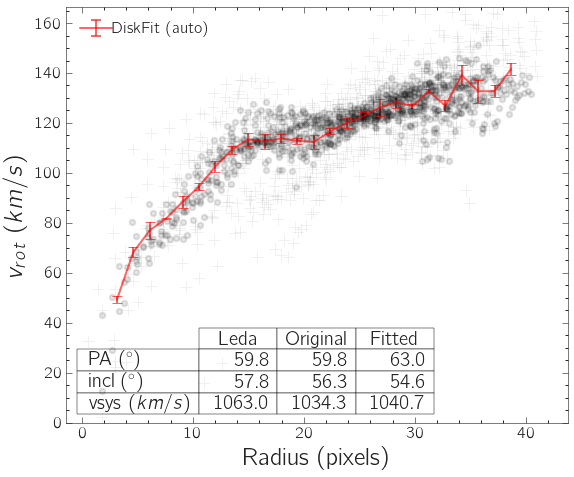

In [0]:
# PLOTTING!

save_rotcurve=True

# galaxies_set = galaxies_list
# galaxies_set = galaxies_redo
# galaxies_set = ['NGC1672']

# for i in range(0,len(galaxies_set)):
for i in range(0,1):
# for i in [galaxies_list.index('NGC4826')]:
    name = galaxies_set[i]
    print('\n'+name+' selected!')
    gal = tools.galaxy(name)
    if name in galaxies_bad:
        print('Bad galaxy.')
        continue
    
    # Get maps.
    I_mom1 = tools.mom1_get(gal,data_mode,masking=masking)
    hdr    = tools.hdr_get(gal,data_mode_temp,dim=2)
    skycoord = gal.skycoord_grid(header=hdr)
    RA = skycoord.ra.value     # 2D map of RA.
    Dec = skycoord.dec.value   # 2D map of Dec.
    
    # Leda initial values
    gal_leda = Galaxy(name)
    PA_leda   = gal_leda.position_angle
    incl_leda = gal_leda.inclination
    vsys_leda = gal_leda.vsys
    if np.isnan(vsys_leda):
        vsys_leda = np.nanmean(I_mom1)*u.km/u.s
    
    # Parameter initial values
    PA_orig   = gal.position_angle
    incl_orig = gal.inclination
    vsys_orig = gal.vsys
    if np.isnan(vsys_orig):
        vsys_orig = np.nanmean(I_mom1)*u.km/u.s
    bar_PA_orig, bar_R_orig = tools.bar_info_get(gal,data_mode,\
                              radii='pixels',\
                              folder='/media/jnofech/BigData/galaxies/drive_tables/')
    
    # Read outputs!
    xcen_out,ycen_out,PA_out,eps_out,incl_out,vsys_out,bar_PA_out = dig.read_all_outputs(gal,'params',folder,True)
    # Read rotcurves!
    Rd, vrotd, vrot_ed = dig.read_all_outputs(gal,'rotcurve',folder,True)

    # Save outputs into Galaxy object, and Header!
    # (This can also be done by simply using 
    #   `gal = tools.galaxy(name,diskfit_output=True,data_mode=data_mode,mapmode=mapmode)` which does all the
    #   output-reading automatically; but I left the code like this since `dig.read_all_outputs()` provides bar
    #   fit info
    gal.position_angle = PA_out
    gal.inclination = incl_out
    gal.vsys = vsys_out
    gal.center_position = SkyCoord(RA.max() - xcen_out*(RA.max()  - RA.min())/I_mom1.shape[1],\
                                   Dec.min() + ycen_out*(Dec.max() - Dec.min())/I_mom1.shape[0],\
                                   unit=(u.deg,u.deg), frame='fk5')    
    
    # Get mom1 data along the major axis, and then plot 'em.
    pixsizes_deg = wcs.utils.proj_plane_pixel_scales(wcs.WCS(hdr))[0]*u.deg # Pixel width, in deg.
    pixsizes_arcsec = pixsizes_deg.to(u.arcsec)                             # Pixel width, in arcsec.
    X,Y = gal.radius(header=hdr, returnXY=True)     # Coords in disk plane, in pc.
    X = ((X.to(u.pc) / gal.distance.to(u.pc)).value * u.rad.to(u.arcsec)) / pixsizes_arcsec.value # In pixels.
    Y = ((Y.to(u.pc) / gal.distance.to(u.pc)).value * u.rad.to(u.arcsec)) / pixsizes_arcsec.value # In pixels.
    rad = np.sqrt(X**2+Y**2)
    phi = np.arctan2(Y,X)
    vobs = (I_mom1 - vsys_out.value) / (np.sin(incl_out) * np.cos(phi))
    index_narrow = (np.abs(np.cos(phi)) > 0.8)  # Only consider points where cos(phi) is large so vobs doesn't diverge.
    index_wide   = (np.abs(np.cos(phi)) > 0.3)  # Only consider points where cos(phi) is large so vobs doesn't diverge.
    
    showtitle=False
    if ~np.isnan(np.sum(vrotd)):
        vmin = np.max([np.min([vrotd.min()-25,0,np.nanpercentile(vobs,5.0)]),-450])
        vmax = np.min([np.max([vrotd.max()+25,0,np.nanpercentile(vobs,95.0)]),600])
    else:
        vmin = np.max([np.min([0,np.nanpercentile(vobs,5.0)]),-50])
        vmax = np.min([np.max([0,np.nanpercentile(vobs,95.0)]),500])
    p_vrot(Rd,vrotd,vrot_ed,vmin=vmin,vmax=vmax,\
           PA_orig=PA_orig,PA_fit=PA_out,incl_orig=incl_orig,incl_fit=incl_out,\
           bar_PA_orig=bar_PA_orig,bar_PA_fit=bar_PA_out,\
           vsys_orig=vsys_orig,vsys_fit=vsys_out,vobs=vobs,rad=rad,index=index_wide)
#     plt.clf()
    
    # SAVING ROTCURVE!
    if save_rotcurve==True:
        np.savetxt('/media/jnofech/BigData/PHANGS/OtherData/derived/Rotation_curves/'+folder\
                   +name.lower()+"_co21_"+rcmode+"_RC_procedural.txt",\
                   np.c_[Rd*pixsizes_arcsec,vrotd,vrot_ed],\
                   header="Radius[arcsec] Vrot[km/s] Vrot-err[km/s]",fmt="%7.2f",comments='')

# Creating DiskFit-running scripts for each "iteration" for each galaxy
### (Only needed once, BUT needs to be re-run if more galaxies or "iterations" are added.
Current number of iterations: 8.

In [0]:
max_iterations = 8

# 'Enabling' DiskFit scripts, for a specified iteration. 
# (Needs to be run for new script files so that they can actually be used.)
for iteration in range(1,max_iterations+1):
    diskfit_path = '/media/jnofech/BigData/galaxies/'+folder
    # for i in range(0,len(galaxies_list)):
    #     name = galaxies_list[i]
    for i in range(0,len(galaxies_list)):
        name = galaxies_list[i]
        print(name)
        os.system('chmod u+x '+diskfit_path+'run_'+name.lower()+'_v'+str(iteration)+'.s')
    os.system('chmod u+x '+diskfit_path+'run_all_v'+str(iteration)+'.s')

###### Creating scripts for procedural runs

In [0]:
for iteration in range(1,max_iterations+1):

    # Scripts for procedural diskfit run, for each individual galaxy, for each iteration!
    for i in range(0,len(galaxies_list)):
        name = galaxies_list[i]
        indiv_script = '#!/bin/sh\n\
# Script for RUNNING DiskFit for a galaxy, using 7m data!\n\n'
        indiv_script = indiv_script+'rm Output/'+name.lower()+'_v'+str(iteration)+'.bstrp50\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.csv\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.erase\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.mod.fits\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.res.fits\n\n\
./DiskFit<<eof\n\
'+name.lower()+'_v'+str(iteration)+'.inp\n\
eof\n\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.bstrp50\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.csv\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.erase\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.mod.fits\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.res.fits'
        # Save 'indiv_script' again, for SECOND iteration!!
        file = open('/media/jnofech/BigData/galaxies/'+folder+'run_'\
                    +name.lower()+'_v'+str(iteration)+'.s','w')
        file.write(indiv_script)
        file.close()
        print('/media/jnofech/BigData/galaxies/'+folder+'run_'\
                    +name.lower()+'_v'+str(iteration)+'.s')

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Scripts for procedural diskfit runs, for each iteration, for ALL galaxies!
    # (Unused, I think...)

    all_script = '#!/bin/sh\n\
    # Script for RUNNING DiskFit for a bunch of galaxies!!\n\n'
    for i in range(0,len(galaxies_list)):
        name = galaxies_list[i]
        all_script = all_script+'rm Output/'+name.lower()+'_v'+str(iteration)+'.bstrp50\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.csv\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.erase\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.mod.fits\n\
rm Output/'+name.lower()+'_v'+str(iteration)+'.res.fits\n\n\
./DiskFit<<eof\n\
'+name.lower()+'_v'+str(iteration)+'.inp\n\
eof\n\n\n'

    # Save 'run_all_v#'!
    file = open('/media/jnofech/BigData/galaxies/'+folder+'/run_all_v'+str(iteration)+'.s','w')
    file.write(all_script)
    file.close()

###### Creating scripts for CUSTOM runs
(unused; the current DiskFit loop has done a good job of removing the need for such runs)

In [0]:
# CUSTOM DiskFit run, for each galaxy!

galaxies_custom = galaxies_list
Ncustom = 1    # Number of custom diskfit runs for each galaxy in galaxies_custom. Hopefully only 1!

for i in range(0,len(galaxies_custom)):
    name = galaxies_custom[i]
    indiv_script = '#!/bin/sh\n\
# Script for RUNNING DiskFit for a galaxy, using 7m data!\n\n'
    indiv_script = indiv_script+'rm Output/'+name.lower()+'_c'+str(Ncustom)+'.bstrp50\n\
rm Output/'+name.lower()+'_c'+str(Ncustom)+'.csv\n\
rm Output/'+name.lower()+'_c'+str(Ncustom)+'.erase\n\
rm Output/'+name.lower()+'_c'+str(Ncustom)+'.mod.fits\n\
rm Output/'+name.lower()+'_c'+str(Ncustom)+'.res.fits\n\n\
./DiskFit<<eof\n\
'+name.lower()+'_c'+str(Ncustom)+'.inp\n\
eof\n\n\n\
rm Output/'+name.lower()+'_c'+str(Ncustom)+'.bstrp50\n\
rm Output/'+name.lower()+'_c'+str(Ncustom)+'.csv\n\
rm Output/'+name.lower()+'_c'+str(Ncustom)+'.erase\n\
rm Output/'+name.lower()+'_c'+str(Ncustom)+'.mod.fits\n\
rm Output/'+name.lower()+'_c'+str(Ncustom)+'.res.fits'
    # Save 'indiv_script' again, for SECOND Ncustom!!
    file = open('/media/jnofech/BigData/galaxies/'+folder+'run_'\
                +name.lower()+'_c'+str(Ncustom)+'.s','w')
    file.write(indiv_script)
    file.close()
    print('/media/jnofech/BigData/galaxies/'+folder+'run_'\
                +name.lower()+'_c'+str(Ncustom)+'.s')

    # 'Purify' them!
    os.system('chmod u+x '+diskfit_path+'run_'+name.lower()+'_c'+str(Ncustom)+'.s')

# LaTeX Helper
#### Table Row Generator (Tables 2.1, 3.1 in Thesis)

In [0]:
# Updated (7.26.19)
galaxies_lowincl = ['IC5332', 'NGC0628', 'NGC1317', 'NGC1365', 'NGC1433', 'NGC1672',
                    'NGC2566', 'NGC3059', 'NGC3507', 'NGC3596', 'NGC3626', 'NGC4303',
                    'NGC4548', 'NGC4731', 'NGC5134', 'NGC5643']

galaxies_clean = ['IC1954','IC5273','IC5332','NGC0685','NGC1087',\
                  'NGC1385','NGC1511','NGC1546','NGC1559','NGC1637',\
                  'NGC1672','NGC1792','NGC2090','NGC2283','NGC2775',\
                  'NGC2835','NGC2903','NGC3137','NGC3507','NGC3511',\
                  'NGC3521','NGC3596','NGC3621','NGC3626','NGC3627',\
                  'NGC4254','NGC4298','NGC4303','NGC4321','NGC4457',\
                  'NGC4496A','NGC4540','NGC4569','NGC4571','NGC4654',\
                  'NGC4689','NGC4781','NGC4826','NGC4951','NGC5530',\
                  'NGC5643','NGC6300','NGC6744','NGC7496']

galaxies_cleanish = ['IC1954','IC5273','IC5332','NGC0628','NGC0685',\
                     'NGC1087','NGC1097','NGC1300','NGC1317','NGC1365',\
                     'NGC1385','NGC1433','NGC1511','NGC1546','NGC1559',\
                     'NGC1566','NGC1637','NGC1672','NGC1792','NGC1809',\
                     'NGC2090','NGC2283','NGC2566','NGC2775','NGC2835',\
                     'NGC2903','NGC2997','NGC3059','NGC3137','NGC3351',\
                     'NGC3507','NGC3511','NGC3521','NGC3596','NGC3621',\
                     'NGC3626','NGC3627','NGC4207','NGC4254','NGC4293',\
                     'NGC4298','NGC4303','NGC4321','NGC4457','NGC4496A',\
                     'NGC4535','NGC4536','NGC4540','NGC4548','NGC4569',\
                     'NGC4571','NGC4579','NGC4654','NGC4689','NGC4731',\
                     'NGC4781','NGC4826','NGC4941','NGC4951','NGC5042',\
                     'NGC5068','NGC5128','NGC5134','NGC5248','NGC5530',\
                     'NGC5643','NGC6300','NGC6744','NGC7456','NGC7496']

In [0]:
# Settings
data_mode_sfr = 'either'
conbeam = '750pc'

galaxies_set   = tools.galaxies_gen(data_mode='7m',data_mode_sfr='either',\
                                    exclude_custom=['NGC3239','NGC4694'])   # Galaxies with usable DiskFit output
galaxies_set_b = tools.galaxies_gen(data_mode,data_mode_sfr,exclude_custom=['NGC3239','NGC4694'],\
                                    include_sfr=['fuv+w4','nuv+w3'],\
                                    min_res=conbeam)  # Galaxies with <750pc SFR&cube res, and both SFR maps
# print(len(galaxies_set_b))    # Number of usable galaxies in main analysis

# ------------------------------------------------------------
# Do not edit below line

smooth='universal'      # RC smoothing method. <'universal'>, 'brandt', 'simple'. (Only 'universal' implemented.)
customcoords='philipp'  # Custom central coords for each galaxy.
                        #   <'philipp'> (Philipp's values), True (eyeballed values; defunct), False (Leda values).

# Determine which galaxies to skip!
galaxies_badfit_univ = ['NGC4694']
galaxies_badfit_bran = ['NGC4694']
galaxies_badfit_simp = []
galaxies_irreg = ['NGC3239']
if smooth=='universal':
    galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badfit_univ])
elif smooth=='brandt':
    galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badfit_bran])
elif smooth=='simple':
    galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badfit_simp])
logmass = tools.logmass_get(galaxies_set)
hasbar  = tools.hasbar_get(galaxies_set)
hubbleT = tools.hubbleT_get(galaxies_set)
Re      = tools.Re_get(galaxies_set)

for i in range(0,len(galaxies_set)):
    name = galaxies_set[i]
    if name in galaxies_skip:
        continue
    
    with silence():
        # Galaxy with DiskFit input parameters (except for PA, which is from the LSQ optimization post-DiskFit):
        gal       = tools.galaxy(name,customcoords=customcoords,customPA='lsq')
        # Galaxy with DiskFit input parameters:
        gal_noLSQ = tools.galaxy(name,customcoords=customcoords,customPA=True)

    # Call these more neatly. Maybe change PA_get() to PA_getrams().
    with silence():
        I_mom1 = tools.mom1_get(gal,data_mode)
        hdr    = tools.hdr_get(gal,data_mode)

    PA_orig   = gal_noLSQ.position_angle  # Initial PA
    PA_LSQ    = gal.position_angle        # Final PA from LSQ fit
    incl_orig = gal.inclination
    vsys_orig = gal.vsys

    # Read DiskFit outputs!
    with silence():
        xcen_out,ycen_out,PA_out,eps_out,incl_out,vsys_out,bar_PA_out = dig.read_all_outputs(gal,'params',folder,True)
        if customcoords in ['philipp','phil','p']:
            RAcen, Deccen = gal.center_position.ra, gal.center_position.dec   # Output central coords unchanged
        else:
            RAcen, Deccen = tools.pixels_to_wcs(gal,data_mode,xcen_out,ycen_out) # Converts output coords to WCS
        
    # Read smoothed rotcurve params!
    with silence():
        R, vrot, R_e, vrot_e = gal.rotcurve(data_mode,mapmode)
#         R,vrot_s,vmax_urc,rmax_urc,A_urc = rc.RC(gal,data_mode,mapmode,smooth,'smoothed',True) # Smoothed curve.
        R,vrot_s,vmax_urc,rmax_urc,A_urc = rc.RC(gal,data_mode,mapmode,smooth,'LSQurc',True) # LSQ-sampled curve.
        if vmax_urc is None:
            # If there is no LSQ/MC-fitted curve, e.g. because there is no error map:
            raise ValueError('THIS SHOULD NEVER HAPPEN')
            R,vrot_s,vmax_urc,rmax_urc,A_urc = rc.RC(gal,data_mode,mapmode,smooth,'smoothed',True) # Smoothed curve.
    galaxies_best = '?????'
    if galaxies_set[i] in galaxies_list:
        galaxies_best = 'all'
    if galaxies_set[i] in galaxies_cleanish:
        galaxies_best = 'marginal'
    if galaxies_set[i] in galaxies_clean:
        galaxies_best = 'clean'
        
    PA_diskfit   = PA_out
    incl_diskfit = incl_out
    eps_diskfit  = eps_out
    vsys_diskfit = vsys_out
    # noncirc      = False
    # noncirc_PA   = 393.57
    # radflow      = False
    # warp         = False
    # noncirc_m    = 2

    a = " & "
    deg = '$^{\circ}$'
    kms = ' km/s'
    pc = ' pc'
    Mpc = ' Mpc'
    # noncirc_PA   = str(noncirc_PA)+deg
    # if noncirc==False:
    #     noncirc_PA = 'n/a'
    #     noncirc_m  = 'n/a'

# ------------------------------------------------------
# Feel free to edit below here.
    
#     # PAPER (ALL INFO) (PA from LSQurc) 
#     # (OUTDATED; this was from before the thesis was finished)
#     print(galaxies_set[i]+(galaxies_set[i].upper() in galaxies_lowincl)*'*'+a\
#           +"{0:4.6f}".format(RAcen.value)+a+"{0:4.6f}".format(Deccen.value)+a\
#           +"{0:4.1f}".format(gal.distance.to(u.Mpc).value)+a\
#           +"{0:4.0f}".format(PA_LSQ.value)+a+"{0:4.0f}".format(incl_diskfit.value)+a\
#           +"{0:4.0f}".format(vsys_diskfit.value)+a\
#           +"{0:4.0f}".format(vmax_urc)+a\
#           +"{0:4.2f}".format(rmax_urc/1000)+a\
#           +"{0:4.2f}".format(A_urc)+a\
#           +galaxies_best+a\
#           +' \\\\')

    # THESIS B1 (Basic Info)
    print(galaxies_set[i]+(galaxies_set[i].upper() in galaxies_set_b)*'*'+a\
          +"{0:4.6f}".format(RAcen.value)+a+"{0:4.6f}".format(Deccen.value)+a\
          +"{0:4.1f}".format(gal.distance.to(u.Mpc).value)+a\
          +"{0:4.2f}".format(logmass[i])+a\
          +str(hasbar[i])+a\
          +"{0:4.1f}".format(hubbleT[i])+a\
          +(~np.isnan(Re[i])).astype(int)*"{0:4.1f}".format(Re[i].value)+(np.isnan(Re[i]).astype(int)*'$\cdots$')\
          +' \\\\')
    
#     # THESIS B2 (FITTED Info)
#     print(galaxies_set[i]+(galaxies_set[i].upper() in galaxies_lowincl)*'*'+a\
#           +"{0:4.0f}".format(PA_LSQ.value)+a+"{0:4.0f}".format(incl_diskfit.value)+a\
#           +"{0:4.0f}".format(vsys_diskfit.value)+a\
#           +"{0:4.0f}".format(vmax_urc)+a\
#           +"{0:4.2f}".format(rmax_urc/1000)+a\
#           +"{0:4.2f}".format(A_urc)+a\
#           +galaxies_best\
#           +' \\\\')

# Trash Pile
#### Everything below here is VERY outdated and probably won't work.

In [0]:
def error():
    print('\
         ______ _____  _____   ____  _____  \n\
        |  ____|  __ \\|  __ \\ / __ \\|  __ \\ \n\
        | |__  | |__) | |__) | |  | | |__) |\n\
        |  __| |  _  /|  _  /| |  | |  _  /         -    '+name+'\n\
        | |____| | \\ \\| | \\ \\| |__| | | \\ \\ \n\
        |______|_|  \\_\\_|  \\_\\\\____/|_|  \\_\\ \n ')
    

galaxies_bad = []
for i in range(0,len(galaxies_list)):
    name = galaxies_list[i].upper()
    gal = tools.galaxy(name)
    
    print('~~~ '+name+' ~~~')
    
    print('dist = '+str(gal.distance))
    
    
    # Overrides, done by eyeballing!
    if gal.name.lower()=='ic5332':
        gal.position_angle = 50.*u.deg
    if gal.name.lower()=='ngc3059':
        gal.position_angle = 350.*u.deg
    if gal.name.lower()=='ngc3239':
        gal.position_angle = None
    if gal.name.lower()=='ngc3596':
        gal.position_angle = 85.*u.deg
    if gal.name.lower()=='ngc4303':
        gal.position_angle = 320.*u.deg
    if gal.name.lower()=='ngc4535':
        gal.position_angle = 180*u.deg
    if gal.name.lower()=='ngc4571':
        gal.position_angle = 230.*u.deg
    if gal.name.lower()=='ngc4941':
        gal.position_angle = 190.*u.deg
    
    # Print! And check for errors.
    bad_galaxy = False
    if gal.inclination!=None:
        print('inc  = '+str(gal.inclination.value*(u.deg)))
    else:
        print('inc  = '+str(gal.inclination))
    
    if gal.position_angle!=None:
        print('PA   = '+str(gal.position_angle.value*(u.deg)))
    else:
        print('PA   = '+str(gal.position_angle))

    
    if (gal.inclination==None or gal.position_angle==None or gal.distance==None):
        bad_galaxy = True
        error()
    elif (np.isnan(gal.distance) or np.isnan(gal.inclination) or np.isnan(gal.position_angle)):
        bad_galaxy = True
        error()
        
    if bad_galaxy == True:
        galaxies_bad = np.append(galaxies_bad,gal.name)
    


###### Fig Generator

In [0]:
# Generate the filename.
def generate():
    path = '/media/jnofech/BigData/galaxies/fancyplot/'
    if mode=='beta-beta':
        folder       = 'beta-vs-beta/'
        folder_print = ''
        filename = 'multiple_betas_'+smooth+'-vs-'+smooth2
    elif mode=='rotcurve-phangs-diskfit':
        folder       = 'rotcurves_diskfit/7m/'
        folder_print = ''
        filename = galname+'_rotcurve_phangs-vs-diskfit'+lens
    elif mode=='rotcurve-diskfit':
        folder       = 'rotcurves_diskfit/7mprocedural/'
        folder_print = ''
        filename = galname+'_rotcurve_autodiskfit_'+lens
    elif mode=='rotcurve-smooth':
        folder       = 'rotcurves_smoothed/'
        folder_print = smooth+'/'
        filename = galname+'_vrot'
    elif mode=='tdep-vs-beta':
        folder       = 'tdep-vs-beta/'
        folder_print = smooth+'/'
        filename = 'multiple_depletion_vs_beta_cleanish_diskfit7m_7p5arcsec'
    elif mode=='tdep-vs-A':
        folder       = 'tdep-vs-A/'
        folder_print = smooth+'/'
        filename = 'multiple_depletion_vs_A_cleanish_diskfit7m_7p5arcsec'
    elif mode=='tdep-vs-ApB':
        folder       = 'tdep-vs-ApB/'
        folder_print = smooth+'/'
        filename = 'multiple_depletion_vs_ApB_cleanish_diskfit7m_7p5arcsec'
        
    return folder, folder_print, filename

# Print out the figure name, the figure itself, etc.
def easyprint():
    print( '\\ref{fig:'+folder_print+filename+'}')
    print( '\n')
    if mode in ['tdep-vs-A','tdep-vs-ApB','tdep-vs-beta']:
        print( '\\begin{figure*}\n\
    \includegraphics[width=\\textwidth]{'+folder+folder_print+filename+ext+'}\n\
    \caption{'+description+'}\n\
    \label{fig:'+folder_print+filename+'}\n\
\end{figure*}')
    else:
        print( '\\begin{figure}\n\
    \includegraphics[width=\columnwidth]{'+folder+folder_print+filename+ext+'}\n\
    \caption{'+description+'}\n\
    \label{fig:'+folder_print+filename+'}\n\
\end{figure}')

# galname = galaxies_list[56]
galname = galaxies_cleanish[6]
ext = '.png'
lens = '7m'

# mode = 'beta-beta'       # Choose image type.
# mode = 'rotcurve-phangs-diskfit'
# mode = 'rotcurve-diskfit'
# mode = 'rotcurve-smooth'
mode = 'tdep-vs-beta'

# smooth = 'universal'         # For rotcurve-smooth and beta-beta.

# smooth2 = 'simple'        # For beta-beta.

# ---------------------------------------------------------------
folder, folder_print, filename = generate()

description = "Procedurally-generated rotation curve for "+galname+", part of the \"clean\" sample."


# ---------------------------------------------------------------
easyprint()

\begin{figure}
    \includegraphics[width=\columnwidth]{rotcurves_diskfit/7mprocedural/IC1954_rotcurve_autodiskfit_7m.png}
    \caption{Procedurally-generated rotation curve for IC1954, part of the "clean" sample.}
    \label{fig:IC1954_rotcurve_autodiskfit_7m}
\end{figure}
\begin{figure}
    \includegraphics[width=\columnwidth]{rotcurves_diskfit/7mprocedural/NGC1792_rotcurve_autodiskfit_7m.png}
    \caption{Procedurally-generated rotation curve for NGC1792, part of the "clean" sample.}
    \label{fig:NGC1792_rotcurve_autodiskfit_7m}
\end{figure}
\begin{figure}
    \includegraphics[width=\columnwidth]{rotcurves_diskfit/7mprocedural/NGC2090_rotcurve_autodiskfit_7m.png}
    \caption{Procedurally-generated rotation curve for NGC2090, part of the "clean" sample.}
    \label{fig:NGC2090_rotcurve_autodiskfit_7m}
\end{figure}
\begin{figure}
    \includegraphics[width=\columnwidth]{rotcurves_diskfit/7mprocedural/NGC2835_rotcurve_autodiskfit_7m.png}
    \caption{Procedurally-generated rotation curve for NGC2835, part of the "clean" sample.}
    \label{fig:NGC2835_rotcurve_autodiskfit_7m}
\end{figure}

\begin{figure}
    \includegraphics[width=\columnwidth]{rotcurves_diskfit/7mprocedural/NGC2903_rotcurve_autodiskfit_7m.png}
    \caption{Procedurally-generated rotation curve for NGC2903, part of the "clean" sample.}
    \label{fig:NGC2903_rotcurve_autodiskfit_7m}
\end{figure}
\begin{figure}
    \includegraphics[width=\columnwidth]{rotcurves_diskfit/7mprocedural/NGC3507_rotcurve_autodiskfit_7m.png}
    \caption{Procedurally-generated rotation curve for NGC3507, part of the "clean" sample.}
    \label{fig:NGC3507_rotcurve_autodiskfit_7m}
\end{figure}
\begin{figure}
    \includegraphics[width=\columnwidth]{rotcurves_diskfit/7mprocedural/NGC3511_rotcurve_autodiskfit_7m.png}
    \caption{Procedurally-generated rotation curve for NGC3511, part of the "clean" sample.}
    \label{fig:NGC3511_rotcurve_autodiskfit_7m}
\end{figure}

### Plots mom1 map with central coords.
##### Outdated. Not really needed since our central-coord problem was solved a long time ago.

In [0]:
galaxies_set = galaxies_list

# for i in range(0,len(galaxies_list)):
# for i in range(0,len(galaxies_set)):
# for i in [0]:
for i in [galaxies_list.index('NGC4254')]:
    name = galaxies_set[i]
    if name in galaxies_bad:
        continue

    print(galaxies_set[i]+" selected!\n")
    name = galaxies_set[i]
    gal = tools.galaxy(name)
    gal2 = Galaxy(name)

    hdr, beam, x, I_mom1, x, x, x, x, x = tools.info(gal,None,data_mode_temp)
    I_mom1 = tools.mom1_get(gal,data_mode)
    
    
    # Generate RA,Dec maps BEFORE modification.
    # (!) ----> RA, DEC (2D maps) DO NOT VARY WITH GALAXY OBJECT.
    # (!) ----> rad (2D map) VARIES WITH ????
    #    Custom Gal
    skycoord = gal.skycoord_grid(header=hdr)
    RA = skycoord.ra.value     # 2D map of RA.
    Dec = skycoord.dec.value   # 2D map of Dec.
    #    Default Gal
    skycoord2 = gal2.skycoord_grid(header=hdr)
    RA2 = skycoord2.ra.value     # 2D map of RA.
    Dec2 = skycoord2.dec.value   # 2D map of Dec.
    rad2 = gal2.radius(header=hdr).value
    
    
    # Central coords! (Degrees, then pixels.) [s](Let's try back to Degrees again, actually.)[/s]
    #   Custom Gal
    RAcen1 = gal.center_position.ra.value
    Deccen1 = gal.center_position.dec.value
    xcen_1 = I_mom1.shape[1] * (RA.max() - RAcen1) / (RA.max() - RA.min())
    ycen_1 = I_mom1.shape[0] * (Deccen1 - Dec.min()) / (Dec.max() - Dec.min())
#     RAcen11  = RA.max() - xcen_1*(RA.max()  - RA.min())/I_mom1.shape[1]
#     Deccen11 = Dec.min() + ycen_1*(Dec.max() - Dec.min())/I_mom1.shape[0]
    #   Default Gal
    RAcen2 = gal2.center_position.ra.value
    Deccen2 = gal2.center_position.dec.value
    xcen_2 = I_mom1.shape[1] * (RA.max() - RAcen2) / (RA.max() - RA.min())
    ycen_2 = I_mom1.shape[0] * (Deccen2 - Dec.min()) / (Dec.max() - Dec.min())
#     RAcen21  = RA.max() - xcen_2*(RA.max()  - RA.min())/I_mom1.shape[1]
#     Deccen21 = Dec.min() + ycen_2*(Dec.max() - Dec.min())/I_mom1.shape[0]
    #    Fitted Gal
    xcen_out,ycen_out,x,x,x,x = dig.read_all_outputs(gal,'params',folder,True)
    RAcenout  = RA.max() - xcen_out*(RA.max()  - RA.min())/I_mom1.shape[1]
    Deccenout = Dec.min() + ycen_out*(Dec.max() - Dec.min())/I_mom1.shape[0]
    #    Header, RA/Dec
    RAcen3 = hdr['CRVAL1']
    Deccen3 = hdr['CRVAL2']
    xcen_3 = I_mom1.shape[1] * (RA.max() - RAcen3) / (RA.max() - RA.min())
    ycen_3 = I_mom1.shape[0] * (Deccen3 - Dec.min()) / (Dec.max() - Dec.min())
    #    Header, pixelcoords
    xcen_4 = hdr['CRPIX1']-1.0
    ycen_4 = hdr['CRPIX2']-1.0
    RAcen4  = RA.max() - xcen_4*(RA.max()  - RA.min())/I_mom1.shape[1]
    Deccen4 = Dec.min() + ycen_4*(Dec.max() - Dec.min())/I_mom1.shape[0]
    
    
    # Plotting!
    # With RA/Dec coords!
    plt.imshow(I_mom1,origin='lower',vmin=np.percentile(I_mom1[~np.isnan(I_mom1)],[5.,95.0])[0],\
                                     vmax=np.percentile(I_mom1[~np.isnan(I_mom1)],[5.,95.0])[1],\
               extent=[RA.max(),RA.min(),Dec.min(),Dec.max()], aspect=1)
    if RAcen1!=RAcen2 or Deccen1!=Deccen2:
        plt.plot(RAcen1,Deccen1,'*',label='Custom coords',color='cyan',markersize=20)    # Custom coords.
    plt.plot(RAcen2,Deccen2,'o',label='Default coords',color='blue')                     # Default coords.
    plt.plot(RAcenout,Deccenout,'s',label='Fitted coords',color='gold',markersize=9)     # Fitted coords.
    plt.plot(RAcen3,Deccen3,'.',label='Header RA/Dec coords',color='black')     # Header's RA/Dec coords.
    plt.plot(RAcen4,Deccen4,'*',label='Header Pixel coords',color='black')      # Header's xcen/ycen coords.
    plt.xlabel('RA (degrees)')
    plt.ylabel('Dec (degrees)')
    

    # With pixel coords!
#     plt.imshow(I_mom1,origin='lower',vmin=np.percentile(I_mom1[~np.isnan(I_mom1)],[5.,95.0])[0],\
#                                      vmax=np.percentile(I_mom1[~np.isnan(I_mom1)],[5.,95.0])[1])
#     if xcen_2!=xcen_1 or ycen_2!=ycen_1:
#         plt.plot(xcen_1,ycen_1,'*',label='Custom coords',color='cyan',markersize=20)    # Custom coords.
#     plt.plot(xcen_2,ycen_2,'o',label='Default coords',color='blue')                     # Default coords.
#     plt.plot(xcen_out,ycen_out,'s',label='Fitted coords',color='gold',markersize=9)     # Fitted coords.
#     plt.plot(xcen_3,ycen_3,'.',label='Header RA/Dec coords',color='black')    # Header's RA/Dec coords.
#     plt.plot(xcen_4,ycen_4,'*',label='Header Pixel coords',color='black')    # Header's xcen/ycen coords.
#     plt.xlabel('RA (pixels)')
#     plt.ylabel('Dec (pixels)')
    
    
    plt.gcf().set_size_inches(9,9)
    plt.colorbar()
    plt.legend(loc='best')
    plt.savefig('images/'+name+'_mom1_coords.png')
#     plt.clf()

    PA = gal.position_angle
    print('PA (angle to redshift, CCW from top) : '+str(PA))

In [0]:
# galaxies_set = galaxies_list

for i in range(0,len(galaxies_set)):
# for i in [0]:
# for i in [galaxies_list.index('IC5332')]:
    name = galaxies_set[i]
    if name in galaxies_bad:
        continue
    print(galaxies_set[i]+" selected!\n")
    name = galaxies_set[i]
    
    # Create Galaxy object.
    gal  = tools.galaxy(name)
    gal2 = Galaxy(name)

    # Get header, mom1. (Does not vary with Galaxy object.)
    hdr, beam, x, I_mom1, x, x, x, x, x = tools.info(gal,None,data_mode_temp)
    I_mom1 = tools.mom1_get(gal,data_mode)
    
    # Generate RA,Dec maps BEFORE modification.
    # (!) ----> RA, DEC (2D maps) DO NOT VARY WITH GALAXY OBJECT.
    # (!) ----> rad (2D map) VARIES WITH `gal.center_position`, which varies with header (for skycoord_grid).
    #              The skycoord_grid itself (i.e. RA/Dec maps) change with both CRPIX and CRVAL-- which
    #              are (???)presumably supposed to match perfectly(???)?
#     gal.center_position = SkyCoord(353.62,-36.12,unit=(u.deg,u.deg), frame='fk5')
#     hdr['CRPIX1']+= 30
#     hdr['CRPIX2']+= 10
#     hdr['CRVAL1']+= 0.02
#     hdr['CRVAL2']+= 0.01
    #    Custom Gal
    skycoord = gal.skycoord_grid(header=hdr)
    RA = skycoord.ra.value     # 2D map of RA.
    Dec = skycoord.dec.value   # 2D map of Dec.
    rad = gal.radius(header=hdr).value
    #    Default Gal
    skycoord2 = gal2.skycoord_grid(header=hdr)
    RA2 = skycoord2.ra.value     # 2D map of RA.
    Dec2 = skycoord2.dec.value   # 2D map of Dec.
    rad2 = gal2.radius(header=hdr).value
    
    
    
    # Central coords! (Degrees, then pixels.) [s](Let's try back to Degrees again, actually.)[/s]
    #   Custom Gal
    RAcen1 = gal.center_position.ra.value
    Deccen1 = gal.center_position.dec.value
    xcen_1 = I_mom1.shape[1] * (RA.max() - RAcen1) / (RA.max() - RA.min())
    ycen_1 = I_mom1.shape[0] * (Deccen1 - Dec.min()) / (Dec.max() - Dec.min())
    #   Default Gal
    RAcen2 = gal2.center_position.ra.value
    Deccen2 = gal2.center_position.dec.value
    xcen_2 = I_mom1.shape[1] * (RA.max() - RAcen2) / (RA.max() - RA.min())
    ycen_2 = I_mom1.shape[0] * (Deccen2 - Dec.min()) / (Dec.max() - Dec.min())
    #    Fitted Gal
    xcen_out,ycen_out,x,x,x,x = dig.read_all_outputs(gal,'params',folder,True)
    RAcenout  = RA.max() - xcen_out*(RA.max()  - RA.min())/I_mom1.shape[1]
    Deccenout = Dec.min() + ycen_out*(Dec.max() - Dec.min())/I_mom1.shape[0]
    #    Header, RA/Dec
    RAcen3 = hdr['CRVAL1']
    Deccen3 = hdr['CRVAL2']
    xcen_3 = I_mom1.shape[1] * (RA.max() - RAcen3) / (RA.max() - RA.min())
    ycen_3 = I_mom1.shape[0] * (Deccen3 - Dec.min()) / (Dec.max() - Dec.min())
    #    Header, pixelcoords
    xcen_4 = hdr['CRPIX1']-1.0
    ycen_4 = hdr['CRPIX2']-1.0
    RAcen4  = RA.max() - xcen_4*(RA.max()  - RA.min())/I_mom1.shape[1]
    Deccen4 = Dec.min() + ycen_4*(Dec.max() - Dec.min())/I_mom1.shape[0]
    

    
    # Plotting!
    # With RA/Dec coords!
#     plt.imshow(rad, extent=[RA.max(),RA.min(),Dec.min(),Dec.max()],\
#                origin='lower', aspect=1)
#     if RAcen1!=RAcen2 or Deccen1!=Deccen2:
#         plt.plot(RAcen1,Deccen1,'*',label='Custom coords',color='cyan',markersize=20)    # Custom coords.
#     plt.plot(RAcen2,Deccen2,'o',label='Default coords',color='blue')                     # Default coords.
#     plt.plot(RAcenout,Deccenout,'s',label='Fitted coords',color='gold',markersize=9)     # Fitted coords.
#     plt.plot(RAcen3,Deccen3,'.',label='Header RA/Dec coords',color='white')     # Header's RA/Dec coords.
#     plt.plot(RAcen4,Deccen4,'*',label='Header Pixel coords',color='white')      # Header's xcen/ycen coords.
    
    # With pixel coords!
    plt.imshow(rad, origin='lower', aspect=1) # Rad, of CUSTOM galaxy.
    if xcen_2!=xcen_1 or ycen_2!=ycen_1:
        plt.plot(xcen_1,ycen_1,'*',label='Custom coords',color='cyan',markersize=20)    # Custom coords.
    plt.plot(xcen_2,ycen_2,'o',label='Default coords',color='blue')                     # Default coords.
    plt.plot(xcen_out,ycen_out,'s',label='Fitted coords',color='gold',markersize=9)     # Fitted coords.
    plt.plot(xcen_3,ycen_3,'.',label='Header RA/Dec coords',color='white')    # Header's RA/Dec coords.
    plt.plot(xcen_4,ycen_4,'*',label='Header Pixel coords',color='white')    # Header's xcen/ycen coords.
    
    
    print(RAcen1,Deccen1)
    plt.xlabel('RA (pixels)')
    plt.ylabel('Dec (pixels)')
    plt.gcf().set_size_inches(7,7)
    plt.colorbar()
    plt.legend(loc='best')
#     plt.savefig('images2/'+name+'_rotmap_coords.png')
    plt.clf()